In [41]:
import numpy as np
import healpy as hp
from beamconv import ScanStrategy
%matplotlib inline

In [42]:
import qpoint as qp
print(qp.__file__)

/Users/personal/.local/lib/python3.7/site-packages/qpoint/__init__.py


We start by defining our horizon: a 290K source that occupies a little more than half the sky with sinusoidal elevation.

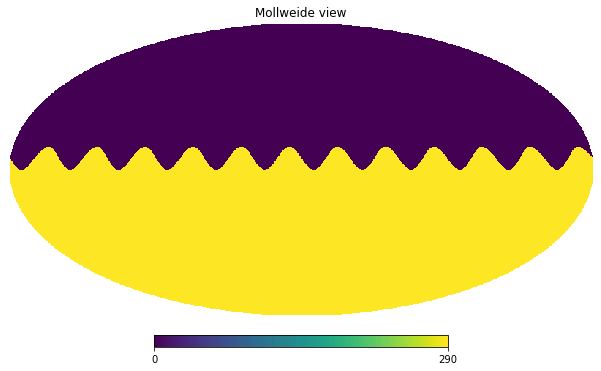

In [43]:
nside = 512
lmax = 700
pixels = np.arange(hp.nside2npix(nside))#all pixels of the healpix map
theta, phi = hp.pix2ang(nside, pixels)#all pixel coordinates 

ground = np.zeros(hp.nside2npix(nside))
ground[theta>(np.pi/2-.1*(np.sin(12*phi)+1))]=290.#horizon condition
alm = hp.map2alm([ground, np.zeros(hp.nside2npix(nside)), np.zeros(hp.nside2npix(nside))], 
                                lmax = lmax)
hp.mollview(ground)

If we look at the auto spectra, there's quite a lot of ringing due to the 'evenness' of the division

Text(0, 0.5, '$D_\\ell^{TT}$ $(K^2)$')

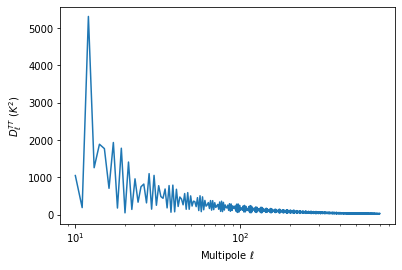

In [44]:
import matplotlib.pyplot as plt

ell = np.arange(lmax+1)
plt.semilogx(ell[10:], ell[10:]*(ell+1)[10:]*hp.anafast(ground, lmax=lmax)[10:]/2/np.pi)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$D_\ell^{TT}$ $(K^2)$')

We also create a beam: it is the sum of two Gaussians, one narrow which is the main beam and one much weaker playing the role of the sidelobes.

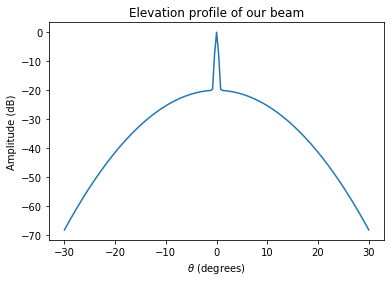

In [45]:
fwhm = np.radians(.5)#main beam, 30 arcmin
side_fwhm = np.radians(15)#sidelobe, 15 degree fwhm!
#1d example
tht = np.linspace(-np.pi/6, np.pi/6, 151)
beam_1d =  0.99*np.exp(-tht**2/(2*(fwhm/2.355)**2))+0.01*np.exp(-tht**2/(2*(side_fwhm/2.355)**2))
#beam_1d =  np.exp(-tht**2/(2*(fwhm/2.355)**2))
plt.plot(tht/np.pi*180., 10*np.log10(beam_1d))
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel('Amplitude (dB)')
plt.title('Elevation profile of our beam')

#Now the full sky-beam
beam = 0.99*np.exp(-theta**2/(2*(fwhm/2.355)**2))+0.01*np.exp(-theta**2/(2*(side_fwhm/2.355)**2))
#off-center secondary
blm = hp.map2alm([beam, beam, np.zeros(hp.nside2npix(nside))], lmax=lmax, mmax=lmax)
np.save('./ancillary/gaussian_with_sidelobe', blm, allow_pickle=True)

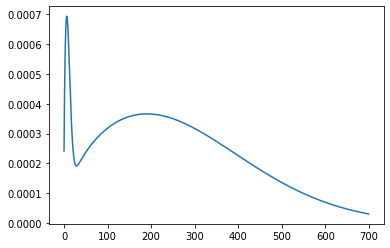

In [46]:
plt.plot(np.absolute(blm[0, hp.Alm.getidx(700, np.arange(700),0)]))

Now for the proper beamconv part: we define beam options for a single detector, and a scan strategy using our ground_scan keyword.

In [47]:
#Beam options
import pickle
beam_file = './ancillary/beam_opts_ssn.pkl'
beam_opts = dict(az=0, el=0, polang=0.,                 
                 btype='PO', lmax=lmax, mmax=lmax, amplitude=1.,
                 po_file='./ancillary/gaussian_with_sidelobe.npy',
                 deconv_q=True, normalize=True, 
                 name='SingleDet')
with open(beam_file, 'wb') as handle:
    pickle.dump(beam_opts, handle, protocol=pickle.HIGHEST_PROTOCOL)

#Scan strategy:

az_throw   = 360.
scan_speed = 0.01
rot_period = 1*60*60
nside_spin = nside
nsamp=3600*24
az0 = 0.
el0 = 15.
# init scan strategy and instrument
sata = ScanStrategy(nsamp, # mission duration in sec.                                  
                  sample_rate=1, # 1 Hz sample rate                                    
                  location='atacama') # Atacama instrument
sata.load_focal_plane('./ancillary', no_pairs=True)


#Pointing
import time
t0 = time.time()
qpo = qp.QPoint()
ra0ata, dec0ata, _, _ = qpo.azel2radec(0,0,0, [az0], [el0], [0.], [0.], [-67.78], [-22.95], [t0])

sata.scan_instrument_mpi(alm, verbose=1, ra0=ra0ata, dec0=dec0ata, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=5, binning=False, ground_scan=True, 
                       scan_speed=scan_speed, el_min=0, check_interval=nsamp)#Reduce repointing that way
sata_tod = sata.tod.copy()
sata_pix = sata.pix.copy()

#Redo but at south pole
spole = ScanStrategy(nsamp, # mission duration in sec.                                  
                  sample_rate=1, # 100 Hz sample rate                                    
                  location='spole') # South pole instrument
spole.load_focal_plane('./ancillary', no_pairs=True)
ra0spo, dec0spo, _, _ = qpo.azel2radec(0,0,0,[az0], [el0], [0.], [0.], [+180.], [-90.], [t0])

spole.scan_instrument_mpi(alm, verbose=1, ra0=ra0spo, dec0=dec0spo, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=5, binning=False, ground_scan=True, 
                          scan_speed=scan_speed, el_min=0, check_interval=nsamp)#Reduce repointing that way
spole_tod = spole.tod.copy()
spole_pix = spole.pix.copy()

Scanning with 2 detectors
[rank 000]: working on: SingleDetA, SingleDetB
[rank 000]:	Working on chunk 000: samples 0-86400
Scanning with 2 detectors
[rank 000]: working on: SingleDetA, SingleDetB


/Users/personal/.local/lib/python3.7/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


[rank 000]:	Working on chunk 000: samples 0-86400


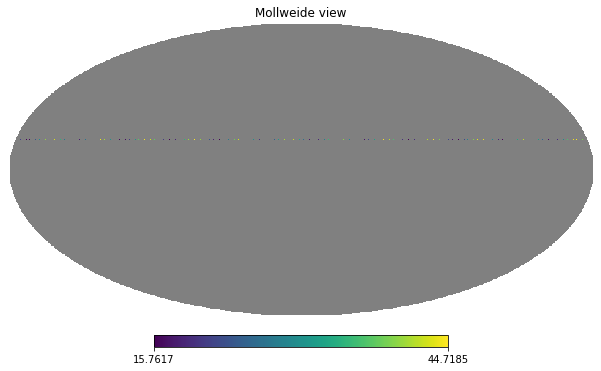

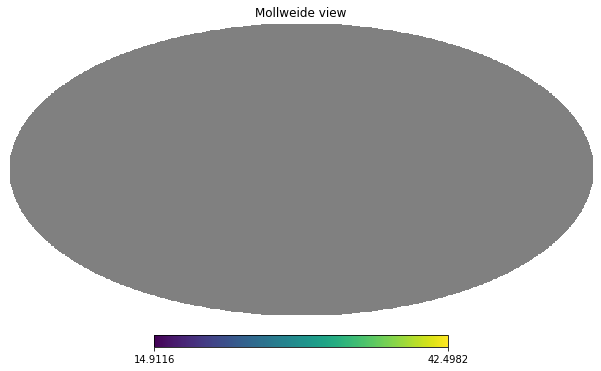

In [48]:
masked_map = np.ones(hp.nside2npix(nside))*hp.UNSEEN
masked_map[sata_pix]=sata_tod
hp.mollview(masked_map)
masked_map = np.ones(hp.nside2npix(nside))*hp.UNSEEN
masked_map[spole_pix]=spole_tod
hp.mollview(masked_map)

Average el spole: 15.098221946639228
Average el atacama: 14.991994952712313


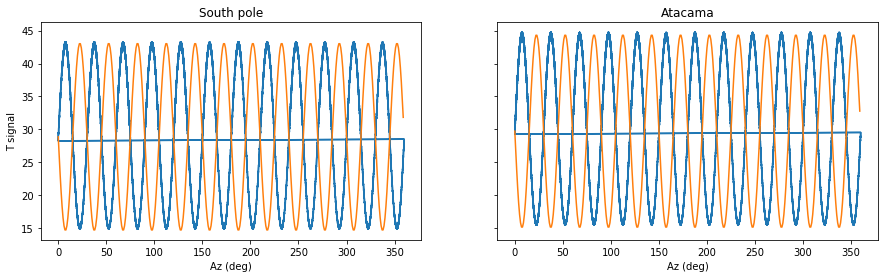

In [49]:
az_pole, el_pole = hp.pix2ang(nside, spole_pix, lonlat=True)
az_ata, el_ata = hp.pix2ang(nside, sata_pix, lonlat=True)
fig, ax= plt.subplots(1,2, sharey='all', figsize=(15,4))
ax[0].plot(az_pole, spole_tod)
ax[1].plot(az_ata, sata_tod)
ax[0].plot(np.arange(360), np.average(spole_tod)-.5*np.ptp(spole_tod)*np.sin(12*np.radians(np.arange(360))))
ax[1].plot(np.arange(360), np.average(sata_tod)-.5*np.ptp(sata_tod)*np.sin(12*np.radians(np.arange(360))))
ax[0].set_ylabel('T signal')
ax[0].set_xlabel('Az (deg)')
ax[1].set_xlabel('Az (deg)')
ax[0].set_title('South pole')
ax[1].set_title('Atacama')

print('Average el spole: {}'.format(np.average(el_pole)))
print('Average el atacama: {}'.format(np.average(el_ata)))

We de-center our sidelobe and run again.

In [50]:
alpha = np.radians(15.)#sidelobe el offset
beta = np.radians(15.)#sidelobe az offset
#Currently can only choose one of the two. Comment in or out at your liking
#New theta after rotation along y axis by alpha: eqivalent to el shift
thetap = np.arccos(np.sin(alpha)*np.sin(theta)*np.cos(phi) + np.cos(alpha)*np.cos(theta))
#New theta after rotation along x axis by alpha: equivalent to az shift
#thetap = np.arccos(np.sin(beta)*np.sin(theta)*np.sin(phi) + np.cos(beta)*np.cos(theta))
beam = 0.99*np.exp(-theta**2/(2*(fwhm/2.355)**2))+0.01*np.exp(-thetap**2/(2*(side_fwhm/2.355)**2))
blm = hp.map2alm([beam, beam, np.zeros(hp.nside2npix(nside))], lmax=lmax, mmax=lmax)
np.save('./ancillary/offcenter_sidelobe', blm, allow_pickle=True)
beam_opts['po_file']='./ancillary/offcenter_sidelobe.npy'
with open(beam_file, 'wb') as handle:
    pickle.dump(beam_opts, handle, protocol=pickle.HIGHEST_PROTOCOL)
sata.load_focal_plane('./ancillary', no_pairs=True, combine=False)
spole.load_focal_plane('./ancillary', no_pairs=True, combine=False)
sata.scan_instrument_mpi(alm, verbose=1, ra0=ra0ata, dec0=dec0ata, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=5, binning=False, ground_scan=True, 
                       scan_speed=scan_speed, el_min=0, check_interval=nsamp)
spole.scan_instrument_mpi(alm, verbose=1, ra0=ra0spo, dec0=dec0spo, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=5, binning=False, ground_scan=True, 
                          scan_speed=scan_speed, el_min=0, check_interval=nsamp)
sata_off_tod = sata.tod.copy()
spole_off_tod = spole.tod.copy()

Scanning with 2 detectors
[rank 000]: working on: SingleDetA, SingleDetB
[rank 000]:	Working on chunk 000: samples 0-86400
Scanning with 2 detectors
[rank 000]: working on: SingleDetA, SingleDetB


/Users/personal/.local/lib/python3.7/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


[rank 000]:	Working on chunk 000: samples 0-86400


Text(0.5, 1.0, 'Atacama')

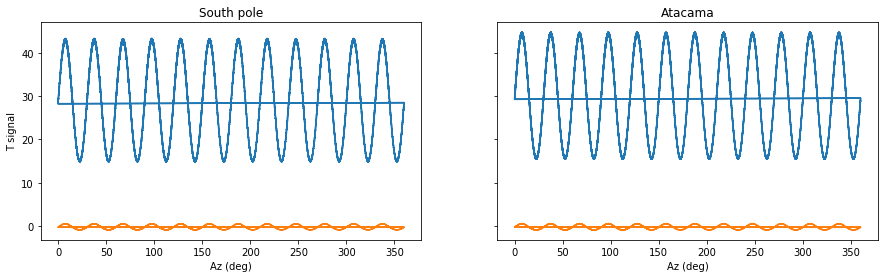

In [51]:
fig, ax= plt.subplots(1,2, sharey='all', figsize=(15,4))
ax[0].plot(az_pole, spole_tod)
ax[0].plot(az_pole, spole_off_tod)
ax[1].plot(az_ata, sata_tod)
ax[1].plot(az_ata, sata_off_tod)
ax[0].set_ylabel('T signal')
ax[0].set_xlabel('Az (deg)')
ax[1].set_xlabel('Az (deg)')
ax[0].set_title('South pole')
ax[1].set_title('Atacama')

Let's do a scan of Atacama, with a different, more realistic ground.

In [105]:
gata = hp.smoothing(hp.read_map('./ancillary/ground_ata95.fits'), fwhm=np.pi/180.)
alm = hp.map2alm([gata, np.zeros_like(gata), np.zeros_like(gata)], lmax = lmax)

beam_opts['po_file']='./ancillary/gaussian_with_sidelobe.npy'
with open(beam_file, 'wb') as handle:
    pickle.dump(beam_opts, handle, protocol=pickle.HIGHEST_PROTOCOL)

t0 = time.time()
qpo = qp.QPoint()
az0 = 0.
el0 = 50.
az_throw   = 360.
scan_speed = 0.1
nsamp = 3600*24

ra0ata, dec0ata, _, _ = qpo.azel2radec(0,0,0, [az0], [el0], [0.], [0.], [-67.78], [-22.95], [t0])

sata = ScanStrategy(nsamp, # mission duration in sec.                                  
                  sample_rate=1, # 1 Hz sample rate                                    
                  location='atacama') # Atacama instrument
sata.load_focal_plane('./ancillary', no_pairs=True)
sata.scan_instrument_mpi(alm, verbose=1, ra0=ra0ata, dec0=dec0ata, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=5, binning=False, ground_scan=True, 
                       scan_speed=scan_speed, el_min=0, check_interval=nsamp)#Reduce repointing that way
sata_tod = sata.tod.copy()
sata_pix = sata.pix.copy()


/opt/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/opt/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/opt/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/opt/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/opt/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 25.479654 arcmin (0.007412 rad) 
  

Scanning with 2 detectors
[rank 000]: working on: SingleDetA, SingleDetB
[rank 000]:	Working on chunk 000: samples 0-86400


/Users/personal/.local/lib/python3.7/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


Text(0, 0.5, 'tod signal')

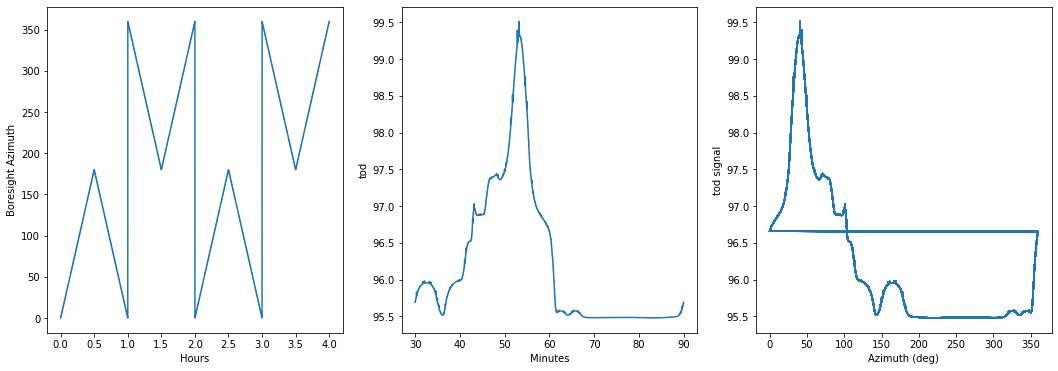

In [106]:
az_ata, el_ata = hp.pix2ang(nside, sata_pix, lonlat=True)
fig, ax =plt.subplots(1,3, figsize=(18,6))
ax[0].plot(np.arange(3600*4)/3600., az_ata[:3600*4])
ax[0].set_xlabel("Hours")
ax[0].set_ylabel("Boresight Azimuth")
ax[1].plot(np.arange(1800, 5400)/60., sata_tod[1800:5400])
ax[1].set_xlabel("Minutes")
ax[1].set_ylabel("tod")
ax[2].plot(az_ata, sata_tod)
ax[2].set_xlabel("Azimuth (deg)")
ax[2].set_ylabel("tod signal")

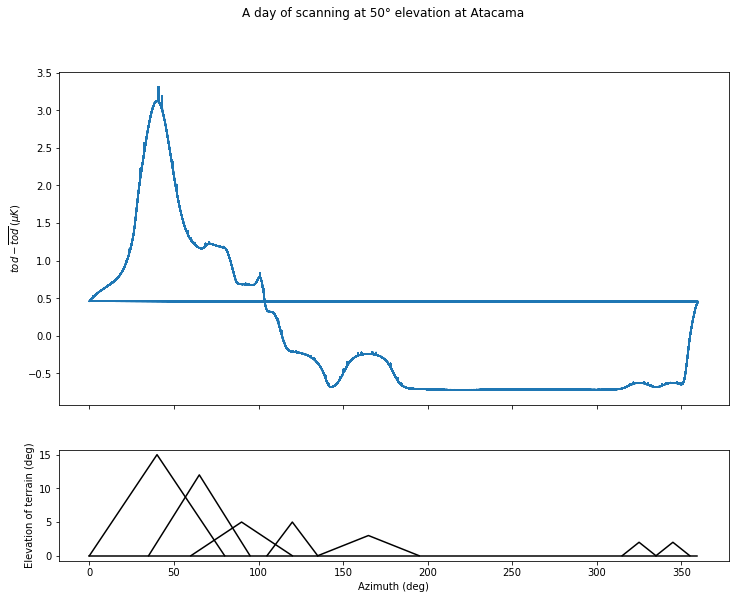

In [107]:
#Overlay the last panel with the mountains:
mount_az = np.array([40,65,90,120,165., 325, 345])
mount_el = np.array([15,12,5,5,3,2,2])
mount_hwidth = np.array([40.,30.,30.,15,30.,10.,10.])


fig, ax = plt.subplots(2,1, figsize=(12,9), sharex=True, gridspec_kw={"height_ratios":[3,1]})
ax[0].plot(az_ata, sata_tod-np.average(sata_tod))
ax[1].set_xlabel("Azimuth (deg)")
ax[0].set_ylabel(r"$tod - \overline{tod} \:(\mu K)$")
for i in range(7):
    ax[1].plot([mount_az[i]-mount_hwidth[i], mount_az[i], mount_az[i]+mount_hwidth[i]], [0, mount_el[i], 0], 'k')
ax[1].plot([0,359],[0,0], 'k')
ax[1].set_ylabel("Elevation of terrain (deg)")
fig.suptitle("A day of scanning at 50° elevation at Atacama")
plt.savefig("SimpleGroundScanSidelobe50")

/opt/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/opt/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


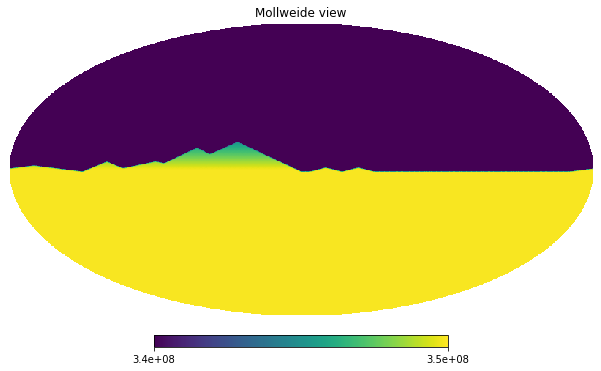

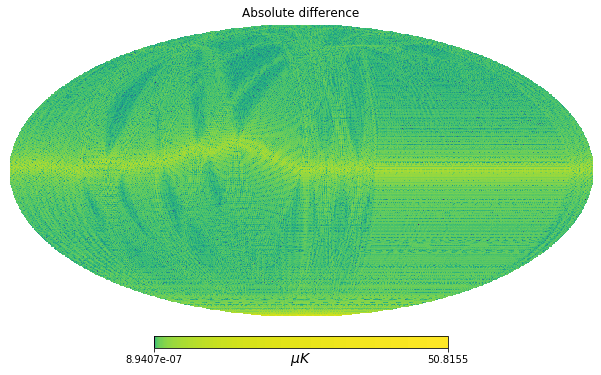

In [101]:
hp.mollview(gata, min=3.4e8, max=3.5e8)
hp.mollview(np.absolute(gata- hp.alm2map(alm, nside=512, lmax=lmax)[0]), norm='log', 
            title='Absolute difference', unit=r'$\mu K$')

Scanning with 2 detectors
[rank 000]: working on: SingleDetA, SingleDetB
[rank 000]:	Working on chunk 000: samples 0-86400


/Users/personal/.local/lib/python3.7/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


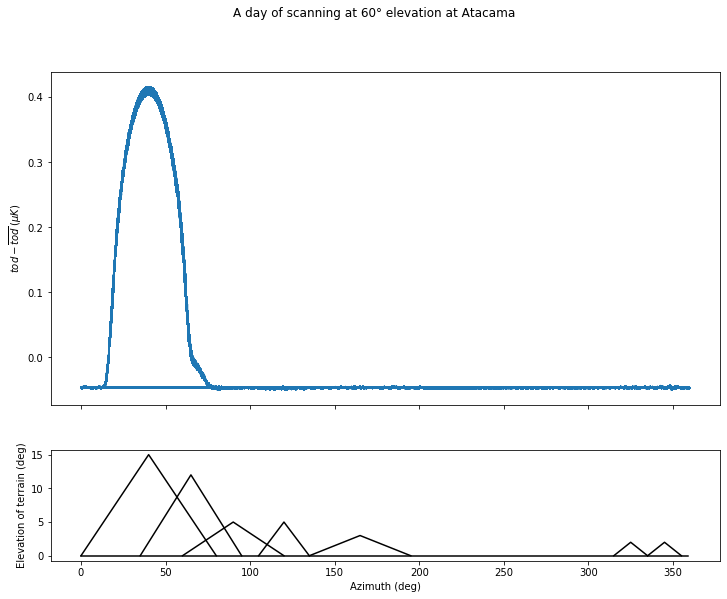

In [108]:
#Same scan at 60° elevation
t0 = time.time()
qpo = qp.QPoint()
az0 = 0.
el0 = 60.
az_throw   = 360.
scan_speed = 0.1
nsamp = 3600*24

ra0ata, dec0ata, _, _ = qpo.azel2radec(0,0,0, [az0], [el0], [0.], [0.], [-67.78], [-22.95], [t0])

sata = ScanStrategy(nsamp, # mission duration in sec.                                  
                  sample_rate=1, # 1 Hz sample rate                                    
                  location='atacama') # Atacama instrument
sata.load_focal_plane('./ancillary', no_pairs=True)
sata.scan_instrument_mpi(alm, verbose=1, ra0=ra0ata, dec0=dec0ata, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=5, binning=False, ground_scan=True, 
                       scan_speed=scan_speed, el_min=0, check_interval=nsamp)#Reduce repointing that way
sata_tod = sata.tod.copy()
sata_pix = sata.pix.copy()

fig, ax = plt.subplots(2,1, figsize=(12,9), sharex=True, gridspec_kw={"height_ratios":[3,1]})
ax[0].plot(az_ata, sata_tod-np.average(sata_tod))
ax[1].set_xlabel("Azimuth (deg)")
ax[0].set_ylabel(r"$tod - \overline{tod} \:(\mu K)$")
for i in range(7):
    ax[1].plot([mount_az[i]-mount_hwidth[i], mount_az[i], mount_az[i]+mount_hwidth[i]], [0, mount_el[i], 0], 'k')
ax[1].plot([0,359],[0,0], 'k')
ax[1].set_ylabel("Elevation of terrain (deg)")
fig.suptitle("A day of scanning at 60° elevation at Atacama")
plt.savefig("SimpleGroundScanSidelobe60")